# ML-8. Ансамблирование. Бэггинг, стекинг, бустинг

In [1]:
# Импортируем библиотеки
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

**Загрузка данных**

In [2]:
# Загрузим датасет из библиотеки
data = load_diabetes(as_frame=True)
# Создаем матрицу наблюдений
X = data['frame'].drop('target', axis=1)
# Создаем вектор правильных ответов
y = data['target']
 
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


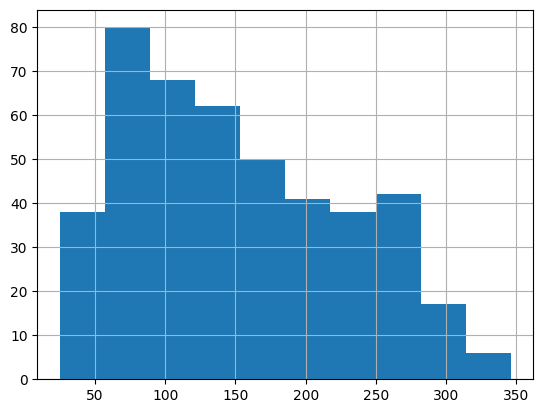

In [3]:
# Посмотрим на распределение целевого признака
y.hist();

In [4]:
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Посмотрим на размерности выборок
print(f'Размерность обучающей выборки {X_train.shape}')
print(f'Размерность тестовой выборки {X_test.shape}')

Размерность обучающей выборки (296, 10)
Размерность тестовой выборки (146, 10)


## Бэггинг: случайный лес. 


In [5]:
# Создаем модель дерева решений с максимальной глубиной 10 
regr1 = DecisionTreeRegressor(max_depth=1000, random_state=42)
# Обучаем модель
regr1.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1000, random_state=42)

In [8]:
# Создаем модель случайного леса из 10 деревьев с максимальной глубиной 10 для каждого дерева 
regr2 = RandomForestRegressor(max_depth=1000, n_estimators=10, random_state=42)
# Обучаем модель
regr2.fit(X_train, y_train)

RandomForestRegressor(max_depth=1000, n_estimators=10, random_state=42)

In [9]:
# Формируем предсказания каждой из моделей
y_pred1 = regr1.predict(X_test)
y_pred2 = regr2.predict(X_test)
 
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для решающего дерева {round(mean_squared_error(y_test, y_pred1),2)}')
print(f'Качество предсказания по MSE для случайного леса  {round(mean_squared_error(y_test, y_pred2),2)}')

Качество предсказания по MSE для решающего дерева 6430.63
Качество предсказания по MSE для случайного леса  3549.09


 ## Стекинг

Стекинг (stacking) — алгоритм построения ансамбля, в котором параллельно и независимо друг от друга обучаются несколько базовых моделей (необязательно одной природы), а их предсказания используются для обучения метамодели (финальная модель) как факторы.

Предсказания базовых алгоритмов называются метапризнаками. 

БЛЕНДИНГ

Простейшая реализация стекинга заключается в блендинге (blending). 

Схематично блендинг можно представить следующим образом:



Суть блендинга состоит в следующем: предположим у нас есть обучающая выборка , которую мы делим пополам. Первая часть используется для обучения базовых моделей, а на второй базовые модели делают предсказания – метапризнаки, на которых уже и обучается в дальнейшем метамодель. 

Недостатки блендинга видны невооруженным глазом: ни базовые модели, ни метамодель не обучаются на полных данных. 

 СТЕКИНГ

Для решения этой проблемы используется усовершенствованная модель блендинга, которая имеет полноценное название — стекинг. Идея борьбы с недостатком блендинга — использование кросс-валидации.

Рассмотрим как обучается классический стекинг. Пусть у нас есть таблица с примерами X и ответами на них y. Количество признаков — , количество наблюдений — , количество моделей в стекинге — .

1
Обучающая выборка разбивается на  равных частей, называемых фолдами. Например, для трёх фолдов () схематично это будет выглядеть следующим образом:

img

2
Затем для каждой базовой модели эти фолды перебираются следующим образом: на каждом шаге фиксируются  фолдов для обучения базовых моделей и один фолд для предсказания (в случае бинарной классификации каждая модель предсказывает вероятность принадлежности к классу 1, в случае мультиклассовой классификации — к каждому классу). В результате будет сформировано  предсказаний, из которых формируется метапризнак , где  — номер модели:

img

Такой подход к формированию метапризнаков позволяет избежать переобучения. Действительно, можно рассматривать -фолд как обучающую выборку, а оставшийся — как тестовую. Таким образом, мы обучаемся на тренировочной выборке, но предсказания делаем для той выборки, которую ещё не видели.

3
После того как мы проделаем шаг 2 для всех базовых моделей, мы получим новый набор данных, состоящий из  метапризнаков — предсказаний каждой из моделей. Предсказания моделей будут использоваться в качестве метапризнаков, на которых будет обучена метамодель.

Пусть мы взяли три разных модели, т. е. . Это будет выглядеть следующим образом:

img

Примечание. Кроме метафакторов, метамодель может использовать для своего обучения изначальные признаки из исходного набора данных.

Давайте посмотрим, как работает алгоритм на конкретной таблице. Пусть у нас есть некоторый набор данных из четырёх признаков, характеризующих клиента (x_0, x_1, x_2 и x_3), и восемь наблюдений. На основе этих признаков необходимо предсказать бинарный целевой признак (y) покупки товара со значениями 1 (купил) и 0 (не купил). Будем использовать стекинг, состоящий из трёх различных моделей.

Разбиваем выборку на четыре фолда, то есть в каждом фолде будет по две строки таблицы (обозначены цветом). Обучаем каждую модель на трёх из этих фолдов и делаем предсказание вероятности покупки для оставшегося.

Из предсказаний будет сформировано три метапризнака (по одному на каждую базовую модель). Это будут предсказанные базовыми классификаторами вероятности покупки (вероятность принадлежности к классу 1).

img

Формируем новый набор данных и отправляем его в метамодель, которая уже и делает финальное предсказание целевого признака покупки:

img

Метамодель будет производить поиск зависимостей в данных и принимать решение уже на основе предсказанных вероятностей покупки, которые были получены на первом этапе. 

В общем случае, когда у нас есть  моделей, общая схема стекинга будет иметь вид:

img

Важно понимать, стекинг — это чистая эвристика, эффективность которой доказана только практическим применением. Стекинг использует тот же подход, что и нейронные сети: предсказания предыдущего этапа (слоя) используются в качестве признаков для следующего этапа (слоя).

С точки зрения смещения и разброса, стекинг не имеет прямой математической интерпретации, так как не минимизирует напрямую ни ту, ни другую компоненту ошибки. Удачно работающий стекинг просто уменьшает ошибку, но гарантий уменьшения смещения или разброса нет.

Есть некоторые рекомендации, как правильно строить стекинг:

В качестве метамоделей лучше всего применять простые модели: например, для задачи регрессии — линейную регрессию, а для задачи классификации — логистическую регрессию.
В качестве базовых моделей лучшего всего использовать модели различной природы.
Из всех ансамблевых методов стекинг применяется реже всего. Главная причина: так как используется много разных моделей, необходимо подбирать их внешние параметры (коэффициенты регуляризации, глубина деревьев, число деревьев, темп обучения и т. д.) в совокупности, а подбор огромного количества параметров очень затратен по времени (мы убедились в этом в модуле по подбору внешних параметров моделей).

Вторая причина — в отличие от бэггинга и бустинга, для стекинга нет каких-то готовых решений, таких как случайный лес и градиентный бустинг над деревьями. Базовые модели нужно подбирать самому, а какие из них подойдут лучше всего — открытый вопрос.

Но, несмотря на эти недостатки, при грамотном подходе опытные специалисты выигрывают соревнования на Kaggle благодаря стекингу. Хотя зачастую таких участников называют «читерами» (от англ. cheat — «жульничать, обманывать»), ведь часто они собирают чуть ли не все возможные ML-модели в стекинг, запускают на мощном сервере подбор внешних параметров и комбинации из этих моделей в стекинге получают заветные 1.5 % прироста качества модели. На Kaggle даже существует фраза — «настекали».

В реальных условиях такой прирост значит мало, поэтому мы не будем концентрироваться на стекинге в нашем курсе, но пример разберём.

In [11]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [12]:
# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', RidgeCV()),
    ('dt',  DecisionTreeRegressor(random_state=42))
]

# Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
# Обучаем модель
reg.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', RidgeCV()),
                              ('dt', DecisionTreeRegressor(random_state=42))],
                  final_estimator=RandomForestRegressor(n_estimators=10,
                                                        random_state=42))

In [13]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test)
# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack), 2)}')

Качество предсказания по MSE для стекинга 3467.74


In [14]:
# Получаем мета-признаки из тренировочных данных
meta_data = reg.transform(X_train)
# Создаем DataFrame
meta_df = pd.DataFrame(
    meta_data, #содержимое таблицы
    columns=['meta_feature1', 'meta_feature2',] #название столбцов
)
meta_df.head()

,meta_feature1,meta_feature2
0,152.477333,154.0
1,202.022338,192.0
2,133.718464,116.0
3,146.698345,81.0
4,169.783292,122.0


 ## Бустинг
 



### Адаптивный бустинг

→ Последней реализацией ансамблирования, которую мы рассмотрим, станет бустинг. Этот метод отличается от предыдущих своей структурой.

Бустинг (boosting) — это алгоритм построения ансамбля, основанный на последовательном построении слабых моделей, причём каждая новая модель пытается уменьшить ошибку предыдущей. После того как все модели обучены, они объединяются в композицию.

Примечание. Под слабыми моделями мы подразумеваем модели, точность которых немногим выше, чем случайное угадывание. Как правило, это короткие деревья решений, они обладают слабой предсказательной способностью.

Обратите внимание, что в бустинге базовые модели обучаются последовательно, а не параллельно, как в предыдущих методах, исправляя ошибки своего «предшественника»  и повышая качество всего ансамбля. 

Бустинг основан на вопросе, поднятом исследователями М. Кернсом и Л. Вэлиантом: «Может ли набор слабых обучающих алгоритмов создать сильный обучающий алгоритм?»

В отличие от бэггинга, бустинг обучается на одном и том же наборе данных, без генерации дополнительных выборок. Однако в процессе обучения меняются так называемые веса наблюдений. Если слабая модель допустила ошибку на каких-то примерах, то значимость (вес) этих примеров увеличивается и на них концентрируется следующая за ней модель.

Представить алгоритм бустинга можно следующей схемой:

img

На схеме  представлено 11 разных наблюдений трёх различных классов (красные, зелёные и синие шарики). После того как модель делает предсказания, мы смотрим, на каких объектах мы угадали класс верно, а на каких ошиблись. Для тех объектов, на которых мы допустили ошибку, мы задаём больший вес. Вес наблюдения обозначается интенсивностью цвета. Чем больше вес наблюдения, тем ярче его цвет.

Так же как и бэггинг, бустинг предназначен для обучения моделей одного типа. То есть нельзя последовательно обучить 50 логистических регрессий, а затем 50 деревьев решения.

Каждая модель создаётся для того, чтобы найти ошибки предыдущей. Сами по себе они решают задачу плохо, но стоит объединить их усилия, и мы получим супермодель.

Очень наглядно будет выглядеть модель бустинга для логистической регрессии при обучении на двух признаках:

img

На рисунке изображено расположение двух линейно неразделимых классов. Нельзя провести одну такую плоскость, которая идеально решает задачу классификации. Раз нельзя одну, давайте проведём две.

Возьмём точки, для которых первая логистическая регрессия совершила ошибку. Увеличим вес этих точек (их значимость). Далее построим такую разделяющую плоскость, которая в первую очередь обращает внимание на наблюдения, имеющие наибольший вес.

Наконец, объединим две модели в одну — получим модель-композицию, которая идеально решает задачу классификации!

Примечание. Когда все модели из ансамбля обучены и составлена композиция из них, для того, чтобы совершить предсказание на новом объекте, необходимо «прогнать» характеристики объекта через все модели в той же последовательности, в которой они обучались, и объединить их результат.

Если бэггинг создавался с целью уменьшить разброс модели, то цель бустинга — уменьшить смещение модели.

Каждый следующий базовый алгоритм в бустинге обучается так, чтобы уменьшить общую ошибку всех своих предшественников. Как следствие, итоговая композиция будет иметь меньшее смещение, чем каждый отдельный базовый алгоритм (хотя уменьшение разброса также может происходить).

В предельном случае модель может обучиться так, что не будет допускать ошибок вовсе. Однако мы знаем, что это не всегда хорошо, ведь в таком случае модель может полностью подстроиться под обучающий набор данных и переобучиться.

Поскольку основная цель бустинга — уменьшение смещения, в качестве базовых моделей часто выбирают алгоритмы с высоким смещением и небольшим разбросом, например короткие деревья решений. У каждого из таких деревьев слабая предсказательная способность, но если их объединить, мы получим очень мощную модель. 

В этом юните мы постараемся затронуть основные шаги эволюции бустинга от первой успешной модели до современных модификаций. Начнём рассмотрение с самой первой модели бустинга — адаптивного бустинга.

АДАПТИВНЫЙ БУСТИНГ 

Первая реализация бустинга называлась AdaBoost. Это модель, которая подразумевает воплощение той самой идеи взвешивания объектов, которую мы рассмотрели выше. Алгоритм предполагает постоянную модификацию объектов выборки путём их взвешивания, причём веса обновляются специальным образом: каждая новая модель из ансамбля обучается на взвешенных данных и обращает большее внимание на ошибки своих предшественников.

Так как алгоритм является несовершенным и в дальнейшем получил свое развитие, мы не будем подробно останавливаться на его работе. Однако приведем краткое описание работы алгоритма на примере задачи бинарной классификации. 

Пусть у нас есть набор данных , в котором  объектов размерности  (вектора в признаковом пространстве размера ) и метки класса , где -1 и 1 — метки отрицательного и положительного класса соответственно.

Будем строить ансамбль из  абстрактных базовых моделей — классификаторов. Обозначим их как  (это могут быть логистические регрессии/деревья решений или что-то ещё).  

1Перед обучением базовой модели мы инициализируем веса объектов обучающей выборки следующим образом: 
2Для всех  от  до :

1. Обучить базовую модель  с учётом весов объектов .

2. Вычислить ошибку классификатора , обозначим её за :



Примечание. Здесь выражение  — это знакомая нам по модулю классификации индикаторная функция. Она равна 1, если ответ  не совпал с предсказанием базовой модели , и 0 — в противном случае.

3. Тогда вес предсказаний данного классификатора (мера «вклада» предсказаний -ой модели в общий ансамбль) вычисляется по формуле: 
Формула веса становится нулевой только при случайном угадывании, то есть когда классификатор ошибается в половине меток — работает ровно так же, как и подбрасывание монетки. Однако остальные будут вносить вес в итоговую модель с положительным или отрицательным знаком (в этом легко убедиться, подставив вероятность ошибки, отличную от 0.5). Тем самым мы исключаем возможность вклада случайных классификаторов в результирующую модель.

4. Обновляем веса объектов в выборке. Для тех объектов, на которых мы допустили ошибку, вес увеличивается; для тех объектов, для которых наш ансамбль предсказал верный ответ — не изменяется. Формула обновления весов:



Видно, что если классификация была произведена верно для объекта , то степень экспоненты будет равна 0, а значит множитель  и вес  не изменится. 

Для того, чтобы привести все веса объектов к единому масштабу от 0 до 1, производится их нормировка путем деления каждого веса  на сумму всех весов:



5. После обучения каждой базовой модели предсказания ансамбля строятся как сумма из предсказаний базовых моделей, взятых с весом :  
.

Примечание. Функция  — функция взятия знака, принимает значение -1, если аргумент функции отрицательный, 0 — если аргумент функции нулевой, и 1 — если аргумент функции положительный.

В чём плюсы такого алгоритма?

✔️ Он прост. Обратите внимание: все математические операции — школьный курс математики, о высшей математике даже не идёт речи. Операции просты в реализации и не требуют вычисления производных, умножений матриц и прочих сложных математических конструкций.

✔️ Накладные расходы бустинга минимальны. Время построения определяется временем построения базовых моделей.

✔️ Показывает хорошую обобщающую способность.

✔️ Имеет возможность идентификации шумовых объектов в ряде случаев.

Но в чём минусы?

⛔️ Жадное добавление алгоритмов приводит к неоптимальности композиции.

⛔️ Склонен к переобучению при наличии шума в данных.

⛔️ Алгоритм является эвристикой, и «взвешивание» объектов, на котором он основан, не подкреплено математическим обоснованием.

In [15]:
from sklearn.ensemble import AdaBoostRegressor

# Создаем объект класса дерева решений
dt = DecisionTreeRegressor(
    max_depth=3, #максимальная глубина дерева
    random_state=42 #датчик генератора случайных чисел
)
# Создаем объект класса AdaBoost
ada = AdaBoostRegressor(
    estimator=dt, #базовая модель
    n_estimators=10, #количество моделей в ансамбле
    random_state=42 #датчик генератора случайных чисел
)
# Обучаем модель
ada.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
ada_pred  = ada.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для AdaBoost {round(mean_squared_error(y_test, ada_pred),2)}')


Качество предсказания по MSE для AdaBoost 3040.83


### Градиентный бустинг (регрессия)

Градиентный бустинг (Gradient Boosting, GB) — это наиболее обобщённая версия бустинга, закреплённая математическим обоснованием. Впервые алгоритм был опубликован профессором статистики Стэнфордского университета Джеромом Фридманом. Алгоритм оказался очень эффективным и в дальнейшем был множество раз модифицирован — до Extreme Gradient Boosting (XgBoost) и других модификаций, таких как CatBoost от Яндекса и LightGMB от Microsoft.

Сейчас градиентный бустинг и его модификации применяются практически везде. Любой запрос на Яндексе, выбор отеля на Booking или сериала на Netflix — всё это работает на градиентном бустинге. 

→ В этом модуле мы кратко рассмотрим принцип работы, а в модулях по математике разберём математическую формализацию алгоритма. 

В GB принцип классического бустинга сохраняется: каждый последующий алгоритм улучшает предыдущий, но, в отличие эвристического «взвешивания» наблюдений, градиентный бустинг использует информацию о функции потерь для построения нового алгоритма. 

Допустим, у нас есть некоторая функция потерь . Она зависит от двух аргументов:  — истинный ответ,  — прогноз модели . Причём неважно, какая это функция потерь (на самом деле ограничение есть — это дифференцируемость функции, то есть существование производной).

Для задачи регрессии это может быть, например, MSE:

Для задачи классификации это может быть, например, logloss:

Примечание. Для logloss  в данном контексте означает не предсказанный класс для -ого наблюдения, а вероятность принадлежности к классу 1 -ого наблюдения, то есть на самом деле . Чистая формальность для идентичности записей для регрессии и классификации.

Пусть мы построили какую-то модель, которая решает задачу классификации или регрессии. Обозначим её  — это какая-то функция, которая принимает на вход объекты  и выдаёт для них предсказания. Качество такой модели, скорее всего, будет не очень хорошим, ведь мы обучаем слабые модели.

Однако мы знаем, на каких объектах модель давала точные предсказания, а на каких — ошибалась. Нужно попробовать использовать эту информацию и обучить ещё одну модель .

Допустим, мы знаем, что предсказание первой модели на каком-то объекте  на 10 больше, чем в реальности. То есть . То есть нам необходимо обучить следующую модель  таким образом, чтобы она предсказала для  ответ -10, то есть . Тогда предсказание идеально совпадает с действительностью:

→ Другими словами, следующая модель должна научиться предсказывать ошибки предыдущей.

В реальности вторая модель тоже не сможет обучиться идеально, поэтому обучим третью модель , которая будет «компенсировать» неточности первых двух. Будем продолжать так, пока не построим композицию из  алгоритмов.

Финальная модель (обозначим её за ), ищется в виде композиции из  базовых алгоритмов определённого семейства (например, линейных моделей/деревьев):

 

Этот подход можно интуитивно представить как игру в гольф. Цель гольфиста — закатить мяч в лунку (для нас это значит с абсолютной точностью предсказать ). Гольфист делает свой первый удар, получает новую координату мяча  (у нас это ответы алгоритма ). Следующий удар гольфист производит из положения:   и снова промахивается. Для нас это значит построить следующий алгоритм , который учится предсказывать ошибки предыдущего. После второго удара композиция — новое положение мяча будет равно:
Гольфист делает следующий удар  из положения:  . Новая координата мяча снова приближается к лунке и становится равной композиции:
А затем следует ещё один удар, и ещё один… И так, пока гольфист не попадёт в заветную лунку. А мы продолжаем обучать всё новые и новые модели , пока не сделаем идеального предсказания, двигаясь в сторону минимума функции потерь.

Финальная композиция, состоящая из K ударов будет равна: 
img

Немного математического формализма ↓

Пусть на какой-то момент было обучено  алгоритмов, где . Итоговая композиция будет иметь вид:

Тогда следующее слагаемое, модель  (обозначим её для краткости ), должна строиться по принципу:

Знакомая запись, не правда ли? Она означает, что нам нужно найти такой алгоритм , при котором наблюдается минимум функции потерь.

Чтобы построить эту модель , необходимо определить, что она будет пытаться предсказать.

Наша новая модель , по сути, должна предсказать вектор-столбец сдвигов (ошибок между истинными  и предсказаниями модели). Посмотрим на задачу под другим углом: нужно предсказать такой вектор, который двигает предсказания в сторону уменьшения функции ошибки.

Тут на сцену и выходит градиент, а точнее — антиградиент. Пусть мы пока не знаем математических тонкостей, но мы знаем, что этот вектор направлен в сторону убывания функции. Его и будем предсказывать моделью .

Допустим, мы каким-то образом рассчитаем этот антиградиент на обучающей выборке  (для всех популярных функций потерь уже выведены формулы его расчёта). Это будет просто вектор-столбец из каких-то чисел. Мы умеем предсказывать числа, то есть будем решать задачу регрессии: будем с помощью модели  предсказывать координаты этого вектора антиградиента. Например, можно построить такую модель , чтобы средний квадрат ошибки между её ответами и антиградиентом (MSE) был минимален.

Когда мы построим модель , мы добавим её ответы в композицию, но не все сразу, а умножим ответы на коэффициент  — темп обучения. Этот коэффициент влияет на то, какой вклад каждая следующая модель будет оказывать на общую композицию. То есть:

где  — ансамбль, построенный на -ом этапе,  — новый ансамбль, который будет построен на следующем этапе .

Примечание. Если принять, что предсказания  полностью совпадают с антиградиентом , то получится формула градиентного спуска:

Но градиентный спуск происходит не в пространстве параметров, а в пространстве ответов ансамбля . Что это за пространство и как в нём считать градиенты, мы обсудим, когда будем разбирать градиентный бустинг подробнее.

Сейчас же для нас важно понимать, что каждая новая модель бустинга будет строиться так, чтобы двигать всю композицию вниз по функции потерь — в сторону вектора антиградиента.

Зачем нужен параметр ?

Он позволяет избежать переобучения и плавно приближаться к минимуму функции потерь.

Например, модель для какого-то -ого наблюдения  предсказала, что ошибка (градиент) будет равна -5. Мы могли бы прибавить к полученным ранее ответам модели   эту 5:

Но так мы сразу сведём эту ошибку к 0 и подстроимся под обучающую выборку. Поэтому мы прибавляем не 5, а умножаем 5 на небольшое число , например на 0.1:

Тогда мы будем плавно уменьшать ошибку с каждой новой моделью.

Если базовая модель — это дерево решений, то схематично это будет выглядеть следующим образом:

img

В качестве базовой модели можно использовать всё что угодно, но общепринятым является использование деревьев решений. Практика показывает, что это наилучший выбор, так как деревья решений очень просты в построении и из всех слабых моделей обладают наилучшей способностью описывать сложные зависимости.

Бустинг, использующий в качестве базовой модели дерево решений, называется градиентным бустингом над деревьями решений (Gradient Boosting on Decision Trees, GBDT). 

Схематично работу алгоритма GBDT можно представить следующим образом:

img

Основным преимуществом такой схемы градиентного бустинга является эффективность в поиске нелинейных зависимостей в сравнении с любыми моделями, основанными на решающих деревьях. Это преимущество стало причиной доминирования GBDT на огромном спектре соревнований — от кредитного скоринга до рекомендательных систем.

В заключение введения в градиентный бустинг приведём некоторые рекомендации по выбору внешних параметров алгоритма:

Количество деревьев (n_estimators). Чем больше деревьев вы берёте, тем меньше ошибка на обучающем наборе данных, вплоть до 0, но, как вы понимаете, тем выше шанс переобучиться. Лучше начинать с небольшого количества моделей (50-100), а затем следить за ошибкой на тестовой выборке.
Темп обучения  (learning_rate). Чем выше темп обучения, тем больше вклад каждого следующего дерева будет в модель и тем быстрее вы сойдётесь к минимуму функции потерь и сведёте ошибку к 0. Однако снова высок риск переобучения. Рекомендуемые значения — от 0.01 до 1.
Максимальная глубина деревьев (max_depth). Градиентный бустинг лучше всего работает со слабыми моделями — это короткие деревья решений с глубиной от 1 до 8.
→ Все параметры влияют на обучение комплексно, поэтому их следует подбирать одновременно. О том, какие инструменты для этого существуют, мы поговорим в отдельном модуле.

Чтобы понять, как на градиентный бустинг влияют параметры темпа обучения, максимальной глубины деревьев и количества деревьев, предлагаем вам поиграть с настройками градиентного бустинга интерактивной демонстрации Brilliantly wrong.

Вы можете регулировать следующие параметры:

tree depth — максимальная глубина деревьев;
learning rate — темп обучения;
subsample — процент выборки, отведённый на обучение;
trees — количество деревьев.
На демонстрации вы сможете увидеть, как меняется функция ошибки на тренировочной (train loss) и тестовой (test loss) выборках при изменении параметров, а также как меняется вид разделяющей поверхности.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

# Создаем объект класса градиентный бустинг
gb = GradientBoostingRegressor(
    max_depth=3, #максимальная глубина дерева
    n_estimators=10, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test)

# Оцениваем качество по метрике MSE
print(f'Качество предсказания по MSE для GradientBoostingRegressor {round(mean_squared_error(y_test, gb_pred),2)}')

Качество предсказания по MSE для GradientBoostingRegressor 3477.3


### Градиентный бустинг (классификация)

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [18]:
# Читаем исходные данные к задаче классификации
df = pd.read_csv('data/winequality-red.csv', sep = ';')
df.head(5)

FileNotFoundError: [Errno 2] No such file or directory: 'data/winequality-red.csv'

In [ ]:
# Создаем матрицу наблюдений 
X = df.drop(['quality'],axis = 1)
# Создаем вектор признаков для бинарной классификации
y = (df['quality'] >5).astype(int)

In [ ]:
# Разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)
# Посмотрим на размерности выборок
print(f' Размерность обучающей выборки {X_train.shape}')
print(f' Размерность тестовой выборки {X_test.shape}')

 Размерность обучающей выборки (1071, 11)
 Размерность тестовой выборки (528, 11)


In [ ]:
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    loss='deviance', #функция потерь
    learning_rate=0.1, #темп обучения
    n_estimators=100, #число деревьев
    max_depth=3, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.77      0.77       238
           1       0.81      0.80      0.81       290

    accuracy                           0.79       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.79      0.79      0.79       528



In [ ]:
# Прогнозируем вероятности принадлежности к классам
y_pred_proba = gb.predict_proba(X_test)
print(y_pred_proba)

[[0.7575177  0.2424823 ]
 [0.81931477 0.18068523]
 [0.80325657 0.19674343]
 ...
 [0.0212709  0.9787291 ]
 [0.90355559 0.09644441]
 [0.80946194 0.19053806]]
